In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
os.chdir('..')

from functions.Convert import *
from visualisation.visu_reco import *

import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.conf import SparkConf

from pyspark.sql.functions import isnan, when, count, col, round

In [2]:
#spark = SparkSession \
    #.builder \
    #.appName('Basics') \
    #.getOrCreate()
    
MAX_MEMORY = "10g"

spark = SparkSession \
    .builder \
    .appName("Foo") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/01 18:29:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/01 18:29:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df = spark.read.csv(path='Projet_Recommandation/data/Mall_Customers.csv', header=True, inferSchema=True)

<h1> Analyse des données </h1>

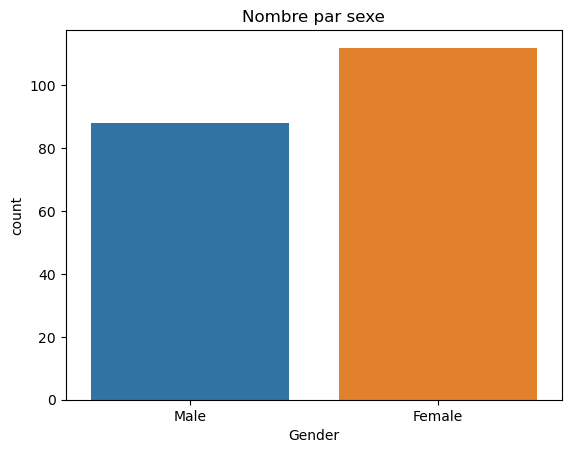

In [4]:
gender_visu(df)

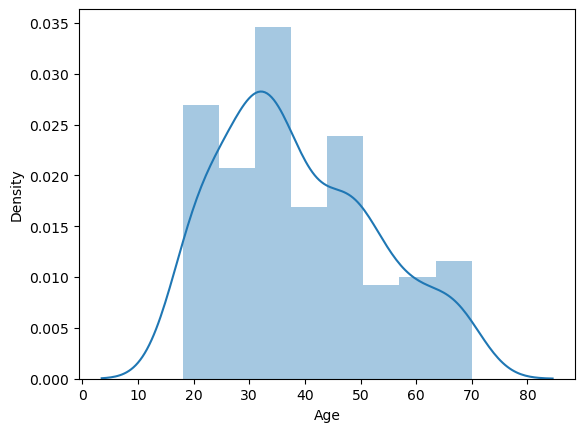

In [5]:
age_visu(df)

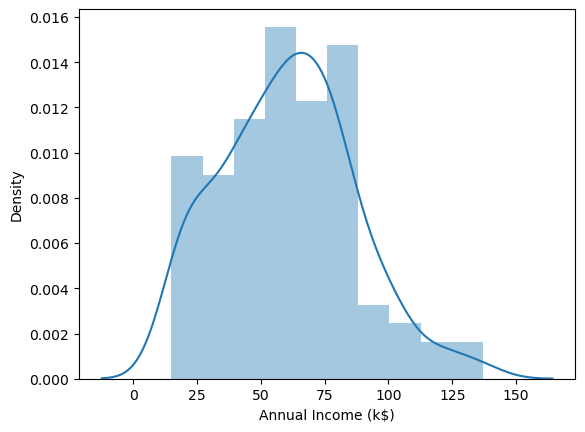

In [6]:
annual_visu(df)

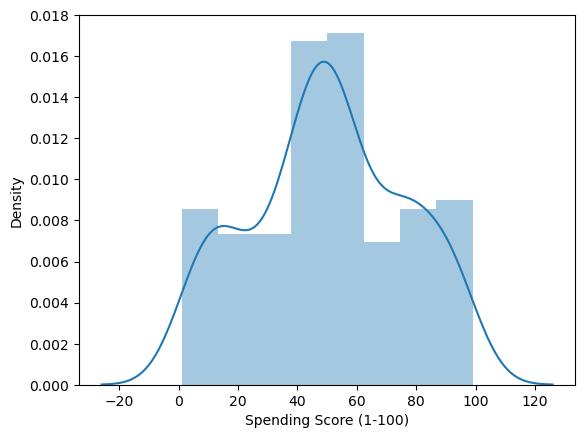

In [7]:
spending_visu(df)

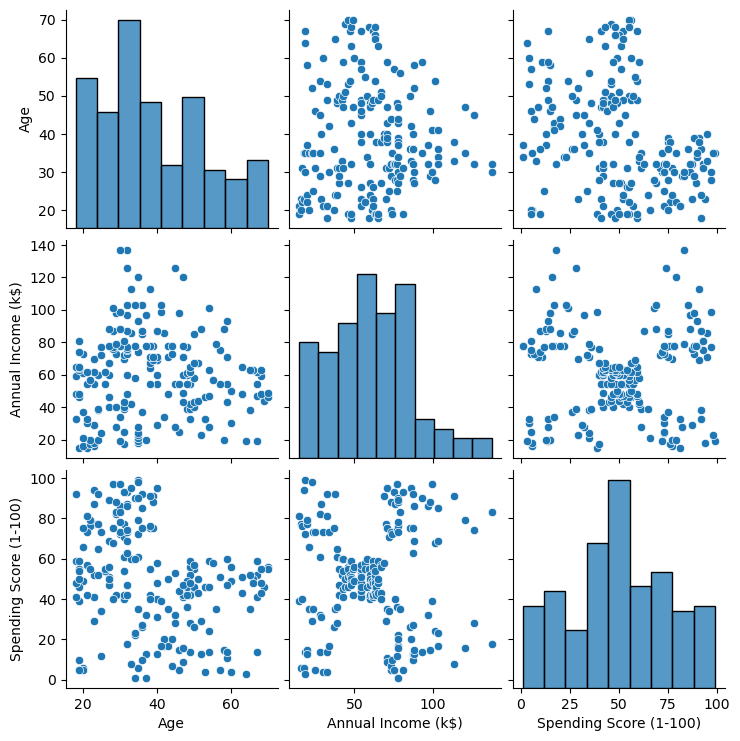

In [8]:
all_visu(df)

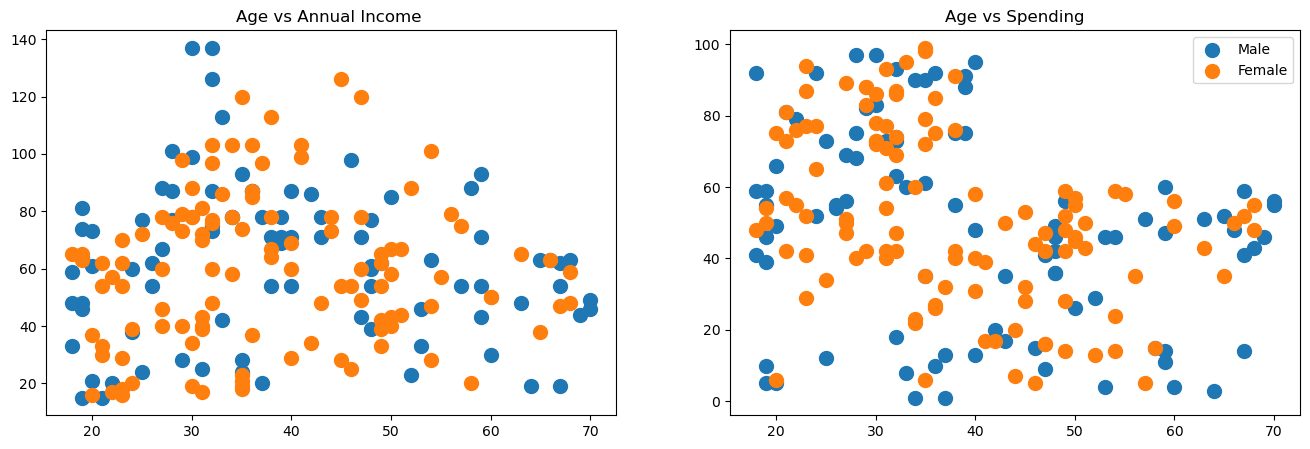

In [9]:
double_visu_MaleFem(df)

<h1> Traitement des données </h1>

In [25]:
df_data_vec = convert_data(df)
#transformer en gender en int 
df_data_vec.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)
 |-- GenderIndexed: double (nullable = false)



In [11]:
df_wiF=convert_vector(df_data_vec)
#mettre en vecteur

In [12]:
#df_standard = stand_vector(df_wiF)

In [13]:
bestM_silou = BestKmeanwithSil(df_wiF,8)
#renvoie lameilleure le nb de cluster 

In [14]:
df_prediction = kmeans_algo(df_wiF,bestM_silou)
#Kmeans

In [15]:
df_prediction.show()

+---+------------------+----------------------+-------------+--------------------+----------+
|Age|Annual Income (k$)|Spending Score (1-100)|GenderIndexed|            features|prediction|
+---+------------------+----------------------+-------------+--------------------+----------+
| 19|                15|                    39|          1.0|[15.0,39.0,19.0,1.0]|         1|
| 21|                15|                    81|          1.0|[15.0,81.0,21.0,1.0]|         0|
| 20|                16|                     6|          0.0| [16.0,6.0,20.0,0.0]|         1|
| 23|                16|                    77|          0.0|[16.0,77.0,23.0,0.0]|         0|
| 31|                17|                    40|          0.0|[17.0,40.0,31.0,0.0]|         1|
| 22|                17|                    76|          0.0|[17.0,76.0,22.0,0.0]|         0|
| 35|                18|                     6|          0.0| [18.0,6.0,35.0,0.0]|         1|
| 23|                18|                    94|          0.0

In [16]:
df_prediction.groupBy('prediction').count().sort(col('prediction')).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   25|
|         1|   23|
|         2|   37|
|         3|   39|
|         4|   76|
+----------+-----+



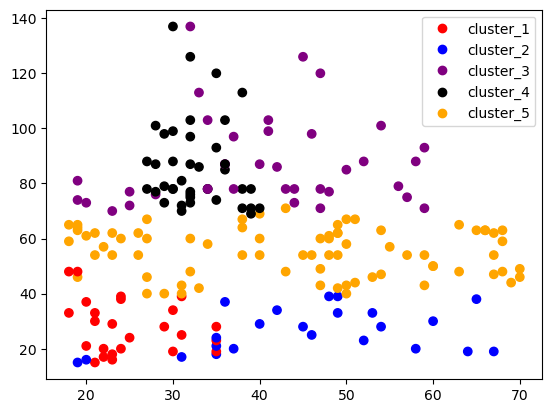

In [17]:
AgeAndIncome(df_prediction)

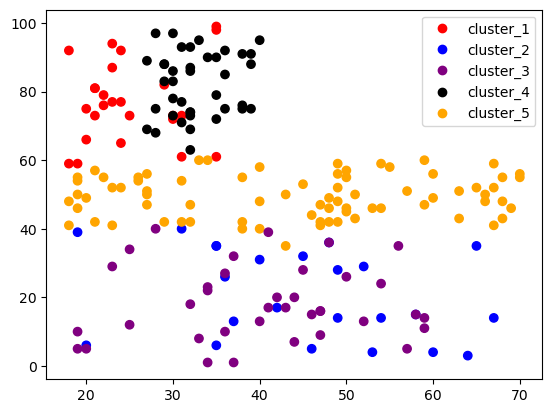

In [18]:
AgeAndScore(df_prediction)

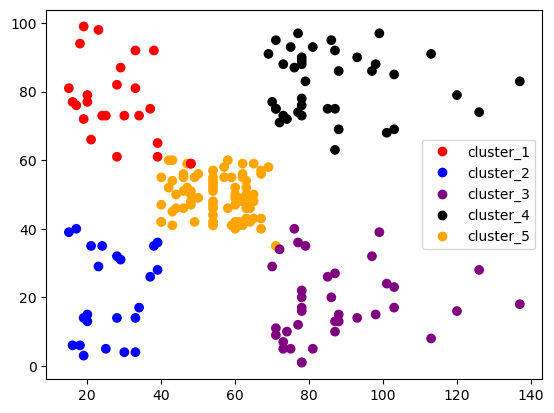

In [20]:
IncomeAndScore(df_prediction)

L'étiquette 0 correspond à un faible revenu et à de faibles dépenses

L'étiquette 1 est un revenu élevé et des dépenses élevées

L'étiquette 2 est un revenu moyen et des dépenses moyennes

L'étiquette 3 est un revenu élevé et de faibles dépenses

L'étiquette 4 est un faible revenu et des dépenses élevées

<h1> Classificateur </h1>

In [21]:
df_prediction = df_prediction.withColumnRenamed("prediction", "prediction_Kmeans")
train, test = df_prediction.randomSplit([0.7, 0.3], seed = 2018)

In [22]:
classificateur(df_prediction,train,test)#random forest

+---+------------------+----------------------+-------------+--------------------+-----------------+--------------------+--------------------+----------+
|Age|Annual Income (k$)|Spending Score (1-100)|GenderIndexed|            features|prediction_Kmeans|       rawPrediction|         probability|prediction|
+---+------------------+----------------------+-------------+--------------------+-----------------+--------------------+--------------------+----------+
| 18|                33|                    92|          1.0|[33.0,92.0,18.0,1.0]|                0|[20.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
| 19|                64|                    46|          1.0|[64.0,46.0,19.0,1.0]|                4|[0.08145299145299...|[0.00407264957264...|       4.0|
| 19|                81|                     5|          1.0| [81.0,5.0,19.0,1.0]|                2|[0.0,1.0,17.0,1.0...|[0.0,0.05,0.85,0....|       2.0|
| 20|                16|                     6|          0.0| [16.0,6.0,20.0

<h3> Logistic Regression </h3>

In [23]:
logicR(train,test)
#Logique régression

23/02/01 19:22:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/01 19:22:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
precision = 1.00
recall   = 1.00
weighted_precision = 1.0
Accuracy = 1.0


<h1>Deuxième jeu de données</h1>

In [26]:
df2 = spark.read.csv(path='Projet_Recommandation/data/small-mall-dataset.csv',header=True, inferSchema=True)

In [36]:
df2.printSchema()

root
 |-- Invoice ID: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Customer type: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Product line: string (nullable = true)
 |-- Unit price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Tax 5%: double (nullable = true)
 |-- Total: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Payment: string (nullable = true)
 |-- cogs: double (nullable = true)
 |-- gross margin percentage: double (nullable = true)
 |-- gross income: double (nullable = true)
 |-- Rating: double (nullable = true)



In [27]:
new_v = transformeD(df2)
#

In [28]:
bestM_silou2 = BestKmeanwithSil(new_v,8)

In [29]:
df_prediction2 = kmeans_algo(new_v,bestM_silou2)

In [30]:
df_prediction2 = df_prediction2.withColumnRenamed("prediction", "prediction_Kmeans")

In [31]:
train2, test2 = df_prediction2.randomSplit([0.7, 0.3], seed = 2018)

<h1> Classificateur 2 </h1>

In [32]:
classificateur(df_prediction2,train2,test2)

+--------------------+---------------+-------------+--------------+-------------+-----------+--------+--------------------+-----------------+-------------+-----------+----------+
|        Product line|CustomerIndexed|GenderIndexed|PaymentIndexed|BranchIndexed|CityIndexed|   Total|            features|prediction_Kmeans|rawPrediction|probability|prediction|
+--------------------+---------------+-------------+--------------+-------------+-----------+--------+--------------------+-----------------+-------------+-----------+----------+
|Electronic access...|            0.0|          0.0|           0.0|          0.0|        0.0|  83.412|           (5,[],[])|                1|   [0.0,20.0]|  [0.0,1.0]|       1.0|
|Electronic access...|            0.0|          0.0|           0.0|          2.0|        2.0|  253.68| (5,[0,3],[2.0,2.0])|                0|   [20.0,0.0]|  [1.0,0.0]|       0.0|
|Electronic access...|            0.0|          0.0|           1.0|          0.0|        0.0| 185.367|   

In [33]:
logicR(train2,test2)

precision = 1.00
recall   = 1.00
weighted_precision = 1.0
Accuracy = 1.0


<h1>PCA avec le premier jeu de données</h1>

In [34]:
df_pca = df_for_pca(df_prediction)
label = PCA_kmeans(df_pca,5)
#print(label)

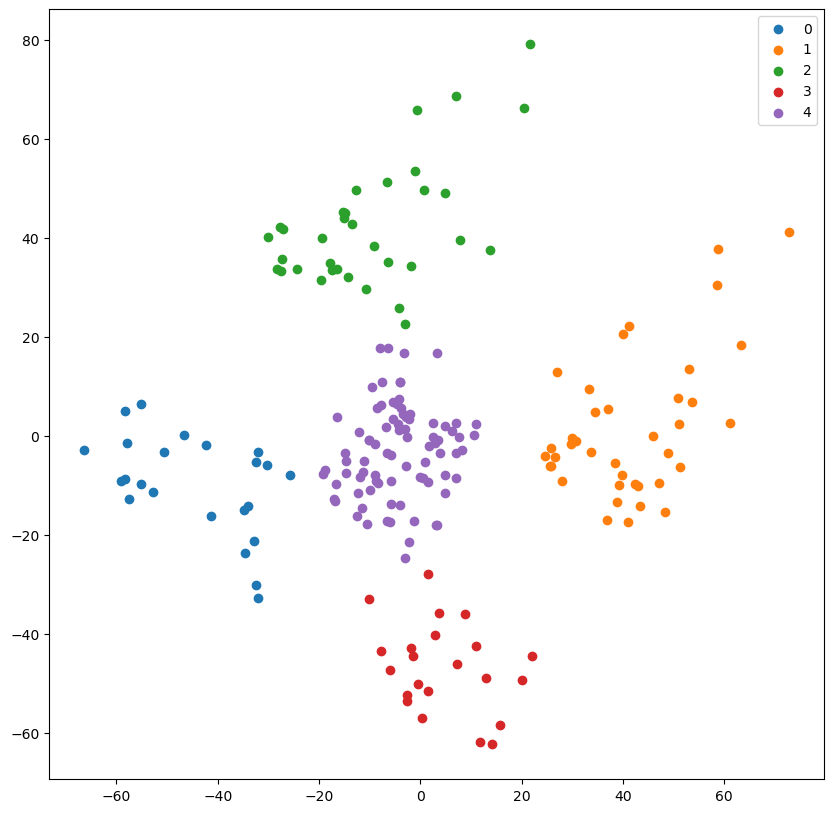

In [35]:
pca_visu(df_pca,label)

In [ ]:
#pca_visu_centroid(df_pca,label)
#erreur à corriger

<h1> Système de recommandation </h1>

In [37]:
movies = spark.read.csv("Projet_Recommandation/data/movies.csv",header=True)
ratings = spark.read.csv("Projet_Recommandation/data/ratings.csv",header=True)

In [41]:
df_ratings = rating_cast(ratings)
df_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
|     1|    665|   5.0|
|     1|    899|   3.5|
|     1|   1088|   4.0|
|     1|   1175|   3.5|
|     1|   1217|   3.5|
|     1|   1237|   5.0|
|     1|   1250|   4.0|
|     1|   1260|   3.5|
|     1|   1653|   4.0|
|     1|   2011|   2.5|
|     1|   2012|   2.5|
|     1|   2068|   2.5|
|     1|   2161|   3.5|
|     1|   2351|   4.5|
|     1|   2573|   4.0|
|     1|   2632|   5.0|
|     1|   2692|   5.0|
+------+-------+------+
only showing top 20 rows



In [38]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [39]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [42]:
reco = ALS_recommandation(df_ratings,10)
reco

RMSE=0.8403858074409425


DataFrame[userId: int, recommendations: array<struct<movieId:int,rating:float>>]

In [43]:
Nbrecommandation=recommandation_tab(reco)
#renoie film et note
# moyenne du film

In [44]:
Nbrecommandation.show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1| 203086| 5.804782|
|     1| 173871| 5.759889|
|     1| 151989| 5.718561|
|     1| 194434|5.6865563|
|     1| 203882| 5.600602|
|     1| 183947|5.4728765|
|     1| 193257|   5.4701|
|     1| 194334|5.4418344|
|     1| 192089|5.2483006|
|     1| 207640|5.2422843|
|     6| 194434| 6.324586|
|     6| 203086| 6.080991|
|     6| 203882|5.9627953|
|     6| 151989| 5.783994|
|     6| 183947|5.7063117|
|     6| 173871| 5.703575|
|     6| 193257| 5.616068|
|     6| 157789| 5.570483|
|     6| 157791| 5.570483|
|     6| 194334| 5.527264|
+------+-------+---------+
only showing top 20 rows



In [45]:
join_rating_movie(movies,Nbrecommandation).filter('userId = 100').show()

+-------+--------------------+--------------------+------+---------+
|movieId|               title|              genres|userId|   rating|
+-------+--------------------+--------------------+------+---------+
| 193257|Familie Brasch (2...|         Documentary|   100|5.6120677|
| 203086|Truth and Justice...|               Drama|   100|5.5448117|
| 194434|   Adrenaline (1990)|  (no genres listed)|   100| 5.469316|
| 203882|Dead in the Water...|              Horror|   100|5.4482026|
| 194334|Les Luthiers: El ...|  (no genres listed)|   100| 5.445797|
| 173871|I'll Take You The...|Comedy|Drama|Romance|   100|5.3621836|
| 151989|    The Thorn (1971)|              Comedy|   100| 5.213784|
| 183947|NOFX Backstage Pa...|  (no genres listed)|   100|  5.18946|
| 192089|National Theatre ...|              Comedy|   100| 5.175419|
| 155923|         Sing (1989)|  (no genres listed)|   100| 5.001781|
+-------+--------------------+--------------------+------+---------+



In [46]:
df_rating_movie = join_rating_movie(ratings,movies)

In [47]:
df_rating_movie.show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|    296|     1|   5.0|1147880044| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    306|     1|   3.5|1147868817|Three Colors: Red...|               Drama|
|    307|     1|   5.0|1147868828|Three Colors: Blu...|               Drama|
|    665|     1|   5.0|1147878820|  Underground (1995)|    Comedy|Drama|War|
|    899|     1|   3.5|1147868510|Singin' in the Ra...|Comedy|Musical|Ro...|
|   1088|     1|   4.0|1147868495|Dirty Dancing (1987)|Drama|Musical|Rom...|
|   1175|     1|   3.5|1147868826| Delicatessen (1991)|Comedy|Drama|Romance|
|   1217|     1|   3.5|1147878326|          Ran (1985)|           Drama|War|
|   1237|     1|   5.0|1147868839|Seventh Seal, The...|               Drama|
|   1250|     1|   4.0|1147868414|Bridge on the Riv...| Adventure|Drama|War|

In [48]:
df_rating_movie.filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|   1193|   100|   5.0|862169731|One Flew Over the...|               Drama|
|    714|   100|   5.0|862169065|     Dead Man (1995)|Drama|Mystery|Wes...|
|   1358|   100|   5.0|862169132|  Sling Blade (1996)|               Drama|
|   1466|   100|   5.0|862169186|Donnie Brasco (1997)|         Crime|Drama|
|   1233|   100|   5.0|862168955|Boot, Das (Boat, ...|    Action|Drama|War|
|    781|   100|   5.0|862168912|Stealing Beauty (...|               Drama|
|   1354|   100|   5.0|862169101|Breaking the Wave...|       Drama|Mystery|
|     85|   100|   4.0|862168835|Angels and Insect...|       Drama|Romance|
|    213|   100|   4.0|862169731|Burnt by the Sun ...|               Drama|
|    260|   100|   4.0|862168435|Star Wars: Episod...|Action|Adventure|...|
+-------+---

In [49]:
df_rating_movie.filter('userId = 100').show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      5|   100|   2.0|862168434|Father of the Bri...|              Comedy|
|     17|   100|   4.0|862168376|Sense and Sensibi...|       Drama|Romance|
|     25|   100|   4.0|862168376|Leaving Las Vegas...|       Drama|Romance|
|     26|   100|   4.0|862168751|      Othello (1995)|               Drama|
|     32|   100|   3.0|862168374|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     36|   100|   4.0|862168434|Dead Man Walking ...|         Crime|Drama|
|     52|   100|   3.0|862168471|Mighty Aphrodite ...|Comedy|Drama|Romance|
|     58|   100|   4.0|862168471|Postman, The (Pos...|Comedy|Drama|Romance|
|     78|   100|   3.0|862168955|Crossing Guard, T...|Action|Crime|Dram...|
|     82|   100|   4.0|862168835|Antonia's Line (A...|        Comedy|Drama|
|     85|   

In [50]:
df_rating_movie.filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|   1193|   100|   5.0|862169731|One Flew Over the...|               Drama|
|    714|   100|   5.0|862169065|     Dead Man (1995)|Drama|Mystery|Wes...|
|   1358|   100|   5.0|862169132|  Sling Blade (1996)|               Drama|
|   1466|   100|   5.0|862169186|Donnie Brasco (1997)|         Crime|Drama|
|   1233|   100|   5.0|862168955|Boot, Das (Boat, ...|    Action|Drama|War|
|    781|   100|   5.0|862168912|Stealing Beauty (...|               Drama|
|   1354|   100|   5.0|862169101|Breaking the Wave...|       Drama|Mystery|
|     85|   100|   4.0|862168835|Angels and Insect...|       Drama|Romance|
|    213|   100|   4.0|862169731|Burnt by the Sun ...|               Drama|
|    260|   100|   4.0|862168435|Star Wars: Episod...|Action|Adventure|...|
+-------+---

In [ ]:
spark.sparkContext.stop()